# Assignment 7 — Neural Network (Completed)


**Student:** Ankesh Kishore

**Module:** 11 — Project: Neural Network for Image Recognition (Letters A, B, C)

**Source:** Provided assignment PDF (📝 ASSIGNMENT 7: NEURAL NETWORK). fileciteturn1file0


## Objective
Implement a two-layer feedforward neural network **from scratch** (NumPy only) to classify 5×6 binary images representing the letters **A, B, C**. Train using backpropagation, show training loss & accuracy plots, and demonstrate sample predictions.


## Contents
1. Theory & brief explanation
2. Dataset (binary patterns for A, B, C)
3. Implementation (NumPy-only neural network)
4. Training, plots and sample predictions
5. Conclusions & submission instructions


## Theory (short)
- **Feedforward neural network:** Input layer → Hidden layer (sigmoid) → Output layer (softmax). 
- **Loss:** Cross-entropy for multi-class classification.
- **Training:** Mini-batch SGD with backpropagation.
- **Activation functions:** Sigmoid for hidden layer, Softmax for output layer.
- **One-hot encoding:** Convert class labels to one-hot vectors for loss calculation.


## Dataset
We create binary 5×6 pixel patterns for letters A, B, and C and flatten them to 30-dimensional vectors. Small random pixel flips are used to augment the dataset for robust training.


## Implementation (run the single code cell below to train and evaluate the model)

The code implements:
- Pattern definition for A, B, C
- Augmentation with random flips
- Two-layer network (sigmoid hidden, softmax output)
- Cross-entropy loss and accuracy
- Mini-batch SGD backpropagation
- Training plots (loss & accuracy)
- Sample predictions and display of images


Epoch 001/200  Loss: 0.8737  Acc: 0.7794
Epoch 020/200  Loss: 0.0117  Acc: 1.0000
Epoch 040/200  Loss: 0.0049  Acc: 1.0000
Epoch 060/200  Loss: 0.0031  Acc: 1.0000
Epoch 080/200  Loss: 0.0022  Acc: 1.0000
Epoch 100/200  Loss: 0.0017  Acc: 1.0000
Epoch 120/200  Loss: 0.0014  Acc: 1.0000
Epoch 140/200  Loss: 0.0012  Acc: 1.0000
Epoch 160/200  Loss: 0.0010  Acc: 1.0000
Epoch 180/200  Loss: 0.0009  Acc: 1.0000
Epoch 200/200  Loss: 0.0008  Acc: 1.0000


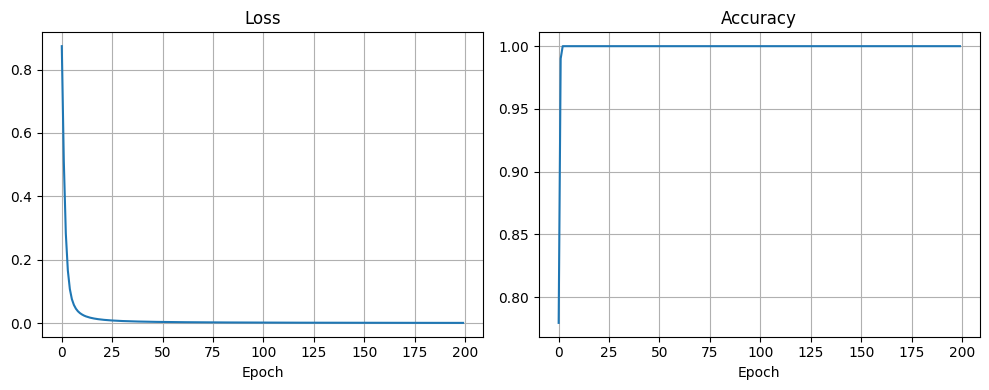

True: A  Pred: A  Probs: [9.99597162e-01 2.64513853e-04 1.38324076e-04]


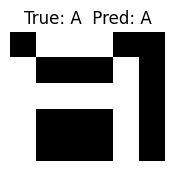

True: B  Pred: B  Probs: [3.14978620e-04 9.99424063e-01 2.60958230e-04]


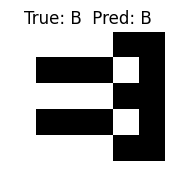

True: C  Pred: C  Probs: [1.56405747e-04 1.72114431e-04 9.99671480e-01]


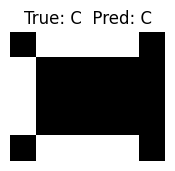

Model training complete. Save this notebook and export as .pdf or .ipynb for submission.


In [4]:

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

# -------------------------
# 1) Create binary patterns
# -------------------------
A = np.array([
    [0,1,1,1,0,0],
    [1,0,0,0,1,0],
    [1,1,1,1,1,0],
    [1,0,0,0,1,0],
    [1,0,0,0,1,0]
], dtype=float)

B = np.array([
    [1,1,1,1,0,0],
    [1,0,0,0,1,0],
    [1,1,1,1,0,0],
    [1,0,0,0,1,0],
    [1,1,1,1,0,0]
], dtype=float)

C = np.array([
    [0,1,1,1,1,0],
    [1,0,0,0,0,0],
    [1,0,0,0,0,0],
    [1,0,0,0,0,0],
    [0,1,1,1,1,0]
], dtype=float)

letters = [A, B, C]
labels_text = ['A', 'B', 'C']

def flatten(img):
    return img.flatten()

X_base = np.vstack([flatten(img) for img in letters])   # shape (3, 30)
Y_base = np.array([0,1,2])  # class indices

# Augment dataset by adding small flips/noise
def augment(data, n_variants=200, flip_prob=0.02):
    X_out = []
    Y_out = []
    for i, x in enumerate(data):
        for _ in range(n_variants):
            v = x.copy()
            mask = (np.random.rand(v.size) < flip_prob)
            v[mask] = 1 - v[mask]
            X_out.append(v)
            Y_out.append(i)
    return np.array(X_out), np.array(Y_out)

X_aug, Y_aug = augment(X_base, n_variants=200, flip_prob=0.02)
X = np.vstack([X_base, X_aug])
Y = np.concatenate([Y_base, Y_aug])

perm = np.random.permutation(len(X))
X = X[perm]
Y = Y[perm]

n_inputs = X.shape[1]   # 30
n_outputs = 3           # A,B,C

def one_hot(y, n_classes):
    oh = np.zeros((len(y), n_classes))
    oh[np.arange(len(y)), y] = 1
    return oh

Y_onehot = one_hot(Y, n_outputs)

# -------------------------
# Network architecture
# -------------------------
n_hidden = 16  # tunable

def init_params(n_in, n_h, n_out):
    W1 = np.random.randn(n_in, n_h) * np.sqrt(2.0/(n_in + n_h))
    b1 = np.zeros((1, n_h))
    W2 = np.random.randn(n_h, n_out) * np.sqrt(2.0/(n_h + n_out))
    b2 = np.zeros((1, n_out))
    return W1, b1, W2, b2

W1, b1, W2, b2 = init_params(n_inputs, n_hidden, n_outputs)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(sig_x):
    return sig_x * (1 - sig_x)

def softmax(z):
    z_shift = z - np.max(z, axis=1, keepdims=True)
    exps = np.exp(z_shift)
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy(preds, targets):
    eps = 1e-12
    preds = np.clip(preds, eps, 1 - eps)
    return -np.mean(np.sum(targets * np.log(preds), axis=1))

def accuracy(preds, labels):
    pred_labels = np.argmax(preds, axis=1)
    return np.mean(pred_labels == labels)

# Training hyperparameters
lr = 0.5
epochs = 200
batch_size = 64

history = {'loss': [], 'acc': []}
N = X.shape[0]

for epoch in range(1, epochs + 1):
    perm = np.random.permutation(N)
    X_sh = X[perm]
    Y_sh = Y_onehot[perm]
    Y_labels_sh = Y[perm]

    epoch_loss = 0.0
    epoch_acc = 0.0
    n_batches = int(np.ceil(N / batch_size))

    for i in range(n_batches):
        start = i * batch_size
        end = min(start + batch_size, N)
        xb = X_sh[start:end]
        yb = Y_sh[start:end]
        yb_labels = Y_labels_sh[start:end]

        # Forward
        z1 = xb.dot(W1) + b1
        a1 = sigmoid(z1)
        z2 = a1.dot(W2) + b2
        a2 = softmax(z2)

        loss = cross_entropy(a2, yb)
        acc = accuracy(a2, yb_labels)
        epoch_loss += loss * (end - start)
        epoch_acc += acc * (end - start)

        # Backprop
        B = xb.shape[0]
        dz2 = (a2 - yb) / B
        dW2 = a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2.dot(W2.T)
        dz1 = da1 * sigmoid_derivative(a1)
        dW1 = xb.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1

    epoch_loss /= N
    epoch_acc /= N
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}/{epochs}  Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

# Plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history['acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions on canonical clean images
def predict(x):
    z1 = x.dot(W1) + b1
    a1 = sigmoid(z1)
    z2 = a1.dot(W2) + b2
    a2 = softmax(z2)
    return a2

for i, img in enumerate(letters):
    x = flatten(img).reshape(1, -1)
    probs = predict(x)
    pred = np.argmax(probs)
    print(f"True: {labels_text[i]}  Pred: {labels_text[pred]}  Probs: {probs.ravel()}")
    plt.figure(figsize=(2,3))
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(f"True: {labels_text[i]}  Pred: {labels_text[pred]}")
    plt.axis('off')
    plt.show()

# Conclusion line
print("Model training complete. Save this notebook and export as .pdf or .ipynb for submission.")
